In [1]:
%matplotlib inline
%load_ext autotime
%load_ext snakeviz
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import datetime as dt
import SIR
import datetime as dt

# Modelling the COVID spread with a SIR model


$$\frac{dS}{dt} = -\beta IS$$

$$\frac{dI}{dt} = \beta IS-\gamma I$$

$$\frac{dR}{dt} = \gamma I$$

Beta:0.2682414613367626 Gamma:0.013042745795461901
R0:20.566333618960407
Predicting with Beta:0.2682414613367626 Beta2: 0.2682414613367626 Gamma:0.013042745795461901


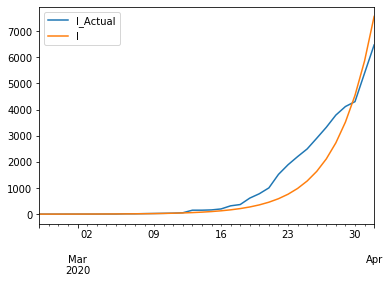

time: 1.29 s


In [2]:
#%%snakeviz ## BETA3
trained = SIR.Learner('Brazil', N=200e6,alpha=0.7)
#out = jap.train()
#jap.estimate()
out = trained.train()
#out = Trained.predict(beta=0.20,gamma=0.07)
trained.I_fit_plot()

Beta:0.3289482233389807 Beta2: 0.19451097330112707 Gamma:0.009119749120793967
R0:36.069876372908645
Predicting with Beta:0.3289482233389807 Beta2: 0.19451097330112707 Gamma:0.009119749120793967


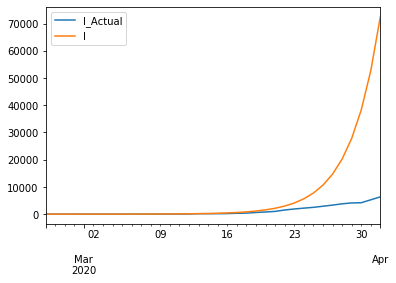

time: 6.21 s


In [3]:
#%%snakeviz ## BETA3
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedBeta=0.3)
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedGamma=0.07)
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedBeta = 0.20,forcedGamma=0.07, daysPredict = 30,nth=1)
custom = SIR.Learner('Brazil', N=200e6, alpha=0.7, forcedGamma=0.07, daysPredict=30, 
                     nth=1, estimateBeta2=True, quarantineDate=dt.datetime(2020,3,15))
custom = SIR.Learner('Brazil', N=200e6, alpha=0.7, daysPredict=30, 
                     nth=1, estimateBeta2=True, recoveredAssumption = 2, quarantineDate=dt.datetime(2020,3,15))

#out = jap.train()
#jap.estimate()
out = custom.train()
#out = custom.predict(beta=0.20,gamma=0.07)
#out = custom.predict(beta=0.20,gamma=None)
custom.I_fit_plot()

In [4]:
0.16/0.01

16.0

time: 2 ms


In [5]:
nonl = custom.df
nonl

,I_Actual,R_Actual,S,I,R
2020-02-26,1.0,0.0,2.000000e+08,1.000000e+00,0.000000e+00
2020-02-27,1.0,0.0,2.000000e+08,1.376905e+00,1.074725e-02
2020-02-28,1.0,0.0,2.000000e+08,1.895834e+00,2.554425e-02
2020-02-29,2.0,0.0,2.000000e+08,2.610334e+00,4.591788e-02
2020-03-01,2.0,0.0,2.000000e+08,3.594568e+00,7.398280e-02
...,...,...,...,...,...
2020-08-24,NaN,NaN,1.483268e+02,6.886715e+07,1.311327e+08
2020-08-25,NaN,NaN,1.387865e+02,6.824196e+07,1.317579e+08
2020-08-26,NaN,NaN,1.299408e+02,6.762245e+07,1.323774e+08
2020-08-27,NaN,NaN,1.217292e+02,6.700856e+07,1.329913e+08


time: 43.9 ms


In [6]:
custom.predict_linear()
l = custom.df
l

Predicting with Beta:0.3289482233389807 Beta2: 0.19451097330112707 Gamma:0.009119749120793967


,I_Actual,R_Actual,S,I,R
2020-02-26,1.0,0.0,2.000000e+08,1.000000e+00,0.000000e+00
2020-02-27,1.0,0.0,2.000000e+08,1.319828e+00,9.119749e-03
2020-02-28,1.0,0.0,2.000000e+08,1.741947e+00,2.115625e-02
2020-02-29,2.0,0.0,2.000000e+08,2.299072e+00,3.704238e-02
2020-03-01,2.0,0.0,2.000000e+08,3.034380e+00,5.800933e-02
...,...,...,...,...,...
2020-08-24,NaN,NaN,1.936409e+02,7.829876e+07,1.217010e+08
2020-08-25,NaN,NaN,1.788952e+02,7.758471e+07,1.224151e+08
2020-08-26,NaN,NaN,1.653966e+02,7.687717e+07,1.231227e+08
2020-08-27,NaN,NaN,1.530303e+02,7.617608e+07,1.238238e+08


time: 24.9 ms


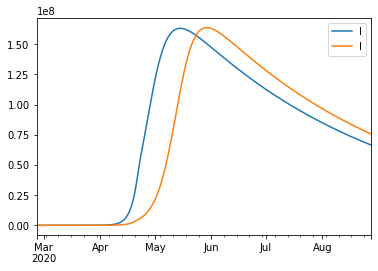

time: 278 ms


In [7]:
pd.DataFrame([nonl["I"],l["I"]]).T.plot()

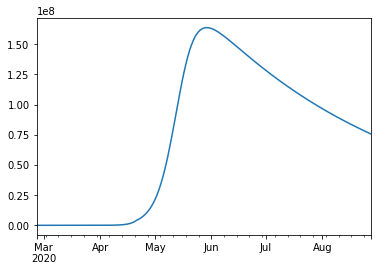

time: 224 ms


In [8]:
l["I"].plot()

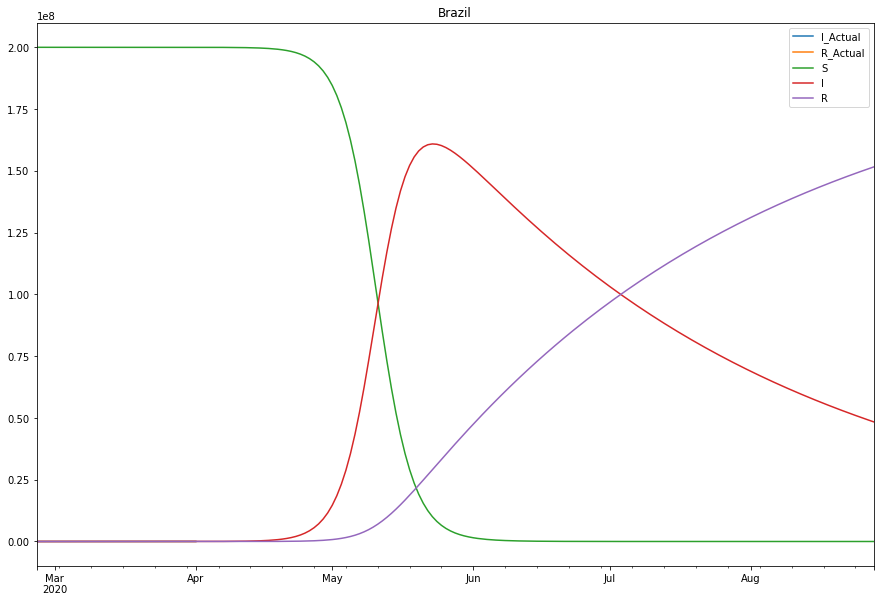

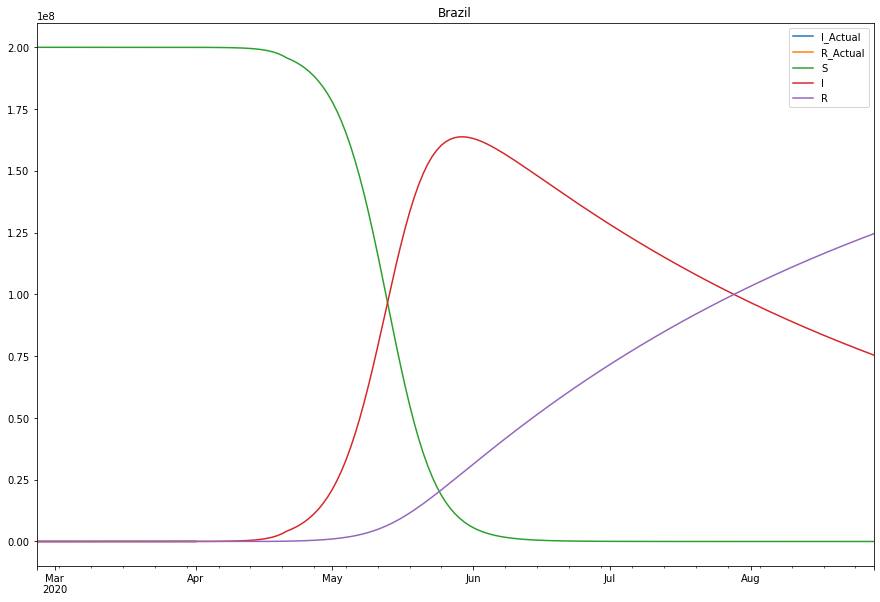

time: 652 ms


In [9]:
trained.main_plot()
custom.main_plot()

In [10]:
#(custom.df - trained.df)
custom.df

,I_Actual,R_Actual,S,I,R
2020-02-26,1.0,0.0,2.000000e+08,1.000000e+00,0.000000e+00
2020-02-27,1.0,0.0,2.000000e+08,1.319828e+00,9.119749e-03
2020-02-28,1.0,0.0,2.000000e+08,1.741947e+00,2.115625e-02
2020-02-29,2.0,0.0,2.000000e+08,2.299072e+00,3.704238e-02
2020-03-01,2.0,0.0,2.000000e+08,3.034380e+00,5.800933e-02
...,...,...,...,...,...
2020-08-24,NaN,NaN,1.936409e+02,7.829876e+07,1.217010e+08
2020-08-25,NaN,NaN,1.788952e+02,7.758471e+07,1.224151e+08
2020-08-26,NaN,NaN,1.653966e+02,7.687717e+07,1.231227e+08
2020-08-27,NaN,NaN,1.530303e+02,7.617608e+07,1.238238e+08


time: 11 ms


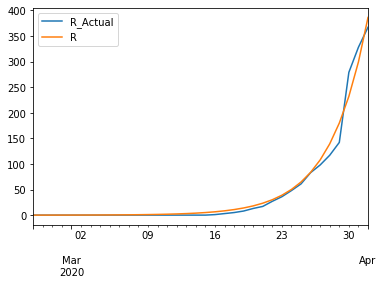

time: 248 ms


In [11]:
trained.R_fit_plot()

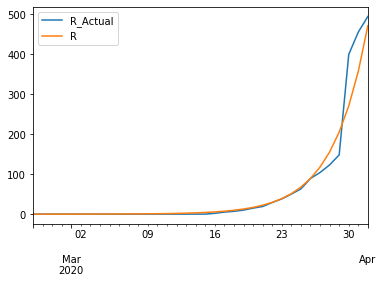

time: 224 ms


In [12]:
custom.R_fit_plot()

Perguntas:
* calibrar parametros na opt
* calibrar beta decay

* Qual o fim da quarentena? Quantos casos sao internação (15% dos confirmados). Leitos na italia (12.5 * 60e6 / 1e5)
* Lag de tempo de internação (novo tratamento caindo de 15 p/ 7)
* Contrai, x (7) dias depois interna, y(10) dias depois sai da internação
* Novos dados | tirar nth day
* fazer brasil e coreia do norte
* fazer dados simulados

Outros:
* prob de contagio usando varios paises
* momento otimo de quarentena
* time varying beta

# Sensitivity Analysis

## Sensitivity to nth

In [13]:
t1 = SIR.Learner('Brazil', N=200e6, alpha=0.7)
t1.train()

Beta:0.2682414613367626 Gamma:0.013042745795461901
R0:20.566333618960407
Predicting with Beta:0.2682414613367626 Beta2: 0.2682414613367626 Gamma:0.013042745795461901
time: 484 ms


In [14]:
t2 = SIR.Learner('Brazil', N=200e6, alpha=0.7, nth=100)
t2.train()

Beta:0.21259852565208054 Gamma:0.010466876592881431
R0:20.31155366794615
Predicting with Beta:0.21259852565208054 Beta2: 0.21259852565208054 Gamma:0.010466876592881431
time: 275 ms


In [15]:
t2 = SIR.Learner('Brazil', N=200e6, alpha=0.7, nth=150)
t2.train()

Beta:0.21259852565208054 Gamma:0.010466876592881431
R0:20.31155366794615
Predicting with Beta:0.21259852565208054 Beta2: 0.21259852565208054 Gamma:0.010466876592881431
time: 265 ms


In [16]:
t2 = SIR.Learner('Brazil', N=200e6, alpha=0.7, nth=1000)
t2.train()

Beta:0.1819064597157342 Gamma:0.01038004284151173
R0:17.524634772050874
Predicting with Beta:0.1819064597157342 Beta2: 0.1819064597157342 Gamma:0.01038004284151173
time: 187 ms


## Sensitivity to infected assumption

In [17]:
t1 = SIR.Learner('Brazil', N=200e6, alpha=0.7, infectedAssumption=1)
t1.train()

Beta:0.2682414613367626 Gamma:0.013042745795461901
R0:20.566333618960407
Predicting with Beta:0.2682414613367626 Beta2: 0.2682414613367626 Gamma:0.013042745795461901
time: 507 ms


In [18]:
t1 = SIR.Learner('Brazil', N=200e6, alpha=0.7, infectedAssumption=2)
t1.train()

Beta:0.26417855484669667 Gamma:0.008470408811112754
R0:31.1884066917889
Predicting with Beta:0.26417855484669667 Beta2: 0.26417855484669667 Gamma:0.008470408811112754
time: 592 ms


In [19]:
t1 = SIR.Learner('Brazil', N=200e6, alpha=0.7, infectedAssumption=3)
t1.train()

Beta:0.2628557241248309 Gamma:0.006978364100950837
R0:37.66724125056981
Predicting with Beta:0.2628557241248309 Beta2: 0.2628557241248309 Gamma:0.006978364100950837
time: 511 ms


In [20]:
t1 = SIR.Learner('Brazil', N=200e6, alpha=0.7, infectedAssumption=4)
t1.train()

Beta:0.26225385343918495 Gamma:0.006291896017059928
R0:41.68121226544534
Predicting with Beta:0.26225385343918495 Beta2: 0.26225385343918495 Gamma:0.006291896017059928
time: 543 ms


## Sensitivity to population

In [21]:
t1 = SIR.Learner('Brazil', N=200e6, alpha=0.7,)
t1.train()

Beta:0.2682414613367626 Gamma:0.013042745795461901
R0:20.566333618960407
Predicting with Beta:0.2682414613367626 Beta2: 0.2682414613367626 Gamma:0.013042745795461901
time: 470 ms


In [22]:
t1 = SIR.Learner('Brazil', N=150e6, alpha=0.7,)
t1.train()

Beta:0.2682417629443224 Gamma:0.01304269437545708
R0:20.56643782507722
Predicting with Beta:0.2682417629443224 Beta2: 0.2682417629443224 Gamma:0.01304269437545708
time: 384 ms


In [23]:
t1 = SIR.Learner('Brazil', N=100e6, alpha=0.7,)
t1.train()

Beta:0.26824236598373236 Gamma:0.013042589937444886
R0:20.566648746167857
Predicting with Beta:0.26824236598373236 Beta2: 0.26824236598373236 Gamma:0.013042589937444886
time: 396 ms


In [24]:
t1 = SIR.Learner('Brazil', N=50e6, alpha=0.7,)
t1.train()

Beta:0.26824417571059905 Gamma:0.013042282351967804
R0:20.567272542610358
Predicting with Beta:0.26824417571059905 Beta2: 0.26824417571059905 Gamma:0.013042282351967804
time: 407 ms


# SEIR Comparison

Beta:0.2682414613367626 Gamma:0.013042745795461901
R0:20.566333618960407
Predicting with Beta:0.2682414613367626 Beta2: 0.2682414613367626 Gamma:0.013042745795461901


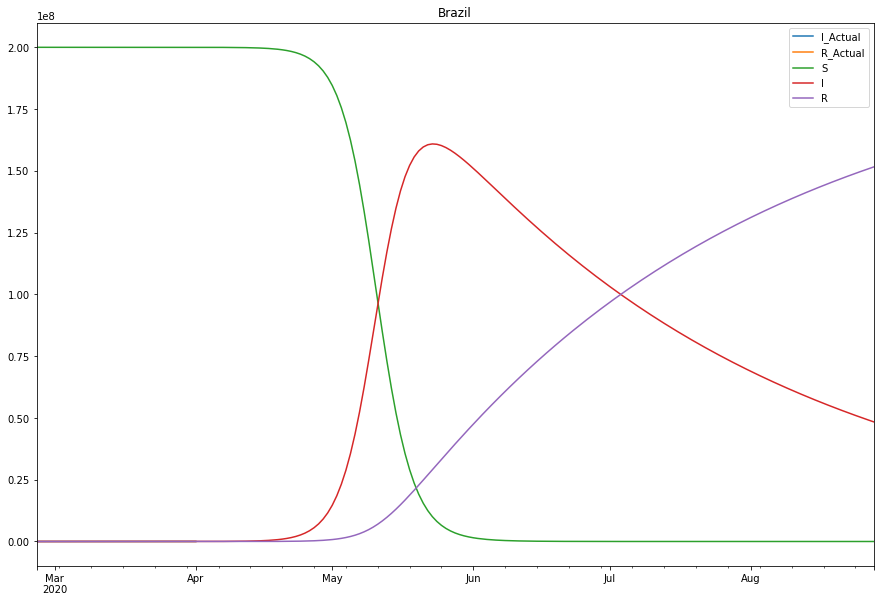

time: 697 ms


In [25]:
seir = SIR.Learner('Brazil', N=200e6, alpha=0.7)
seir.train()
seir.main_plot()

Beta:0.43944665050277426 Gamma:0.07 Sigma:0.2013691327272889
R0:6.277809292896775
Predicting with Beta:0.43944665050277426 Beta2: 0.43944665050277426 Gamma:0.07 Sigma:0.2013691327272889


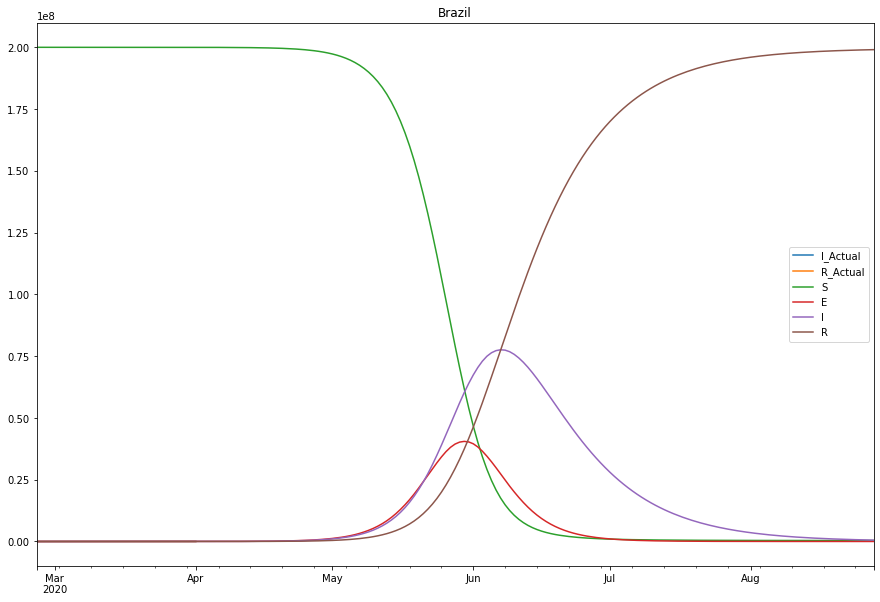

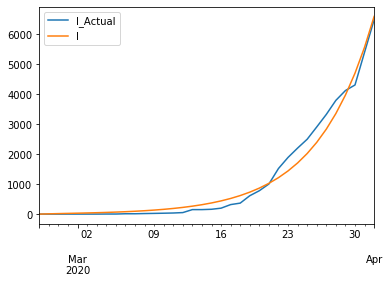

time: 2.79 s


In [26]:
seir = SIR.LearnerSEIR('Brazil', N=200e6, alpha=0.7, elag=15, forcedGamma = 0.07)
seir.train()
seir.main_plot()
seir.I_fit_plot()

## Constrained optimization

In [2]:
t1 = SIR.Learner('Brazil', 
                 N=200e6, 
                 alpha=0.7,
                 betaBounds = (0.1, 0.3),
                 gammaBounds = (0.05, 0.1),
                )
t1.train()

KeyboardInterrupt: 

time: 1min 10s


In [15]:
0.075/ 0.05

1.4999999999999998

time: 1.99 ms


In [19]:
0.09 * 3

0.27

time: 2 ms


In [18]:
.20 / 0.07

2.857142857142857

time: 1.96 ms
